In [1]:
import glob
import json
import os
import re
from pathlib import Path

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns

plt.style.use(["science", "no-latex"])
my_style = {
    "text.usetex": False,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.015,
    "font.size": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.titlesize": 12,
}
plt.rcParams.update(my_style)

In [2]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]


def get_simple_name(dataset_name):
    dataset_name = dataset_name.replace("mnist", "") if dataset_name not in ("mnist", "fmnist") else dataset_name
    return dataset_name


def read_metrics_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df["Method"] = df["Method"].apply(lambda s: s.split()[0])
        df["Split"] = "train" if "_train" in file_path else "test"
        # Query existing levels
        current_levels = list(df.index.names)
        df = df.set_index(["Dataset", "N", "Split"])
        # Create MultiIndex columns
        df = df.pivot(columns="Method", values=["NMSE", "PSNR", "SSI"])
        df.rename(columns={"NMSE": "NRMSE", "SSI": "SSIM"}, level=0, inplace=True)

        # Sort column labels
        df = df.sort_index(axis=1)
        all_data.append(df)

    return pd.concat(all_data).sort_index(
        level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
    )

In [3]:
def read_class_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file, header=[0, 1], index_col=[0, 1])
        # Query existing levels
        current_levels = list(df.index.names)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df = df.set_index(["Dataset", "N"], append=True)
        df = df.reorder_levels(["Dataset", "N"] + current_levels)
        all_data.append(df)

    df = pd.concat(all_data)
    df.columns.set_names("Method", level=1, inplace=True)
    df.rename(columns={"PCA": "PCA"}, level=1, inplace=True)
    df.rename(columns={"Accuracy": "ACC", "F1-Score": "F1"}, level=0, inplace=True)
    df = df[df.index.get_level_values("Classifier") != "Gaussian Naive Bayes"]
    df = df[["ACC", "F1"]]
    df.index = df.index.set_levels(df.index.levels[3].str.lower(), level="Split")
    return df.sort_index(
        level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
    )

In [4]:
def read_loss_interaction_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name

        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"

        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open("r") as info_file:
                experiment_info = json.load(info_file)

        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["losses"] = "$\\frac{" + df["loss1"] + "}{" + df["loss2"] + "}$"
        df = df.drop(["loss1", "loss2"], axis=1)
        # Sort column labels
        # df = df.sort_index(axis=1)
        all_data.append(df)

    return pd.concat(all_data)

In [5]:
experiment = "experiments"

In [6]:
df_metrics = read_metrics_csv_files(f"{experiment}/*/image_metrics_*.csv")
df_metrics.head(6)

NRMSE             PSNR             SSIM        
Method                  PCA   POLCA      PCA    POLCA     PCA   POLCA
Dataset    N  Split                                                  
sinusoidal 8  test   0.1888  0.0157  20.4992  42.7879  0.8351  0.9982
              train  0.1841  0.0059  20.7404  49.9795  0.8432  0.9998
bent       46 test   0.3307  0.0424  14.7451  33.1949  0.6181  0.9942
              train  0.3113  0.0073  15.3123  47.9092  0.6720  0.9999
mnist      11 test   0.5454  0.3362  15.1314  19.4830  0.5013  0.7598
              train  0.5531  0.3335  15.0848  19.6052  0.4956  0.7626

In [7]:
df_class = read_class_csv_files(f"{experiment}/*/classification_metrics_*.csv")
df_class.head(12)

ACC                  F1          
Method                                     PCA     POLCA       PCA     POLCA
Dataset N  Classifier          Split                                        
mnist   11 Linear SVM          test   0.847400  0.959200  0.846933  0.959126
                               train  0.843900  0.955917  0.843304  0.955792
           Logistic Regression test   0.810300  0.948000  0.809644  0.947924
                               train  0.806883  0.944283  0.806156  0.944184
           Perceptron          test   0.699300  0.881600  0.692989  0.878401
                               train  0.688783  0.879700  0.680193  0.876834
           Ridge Classifier    test   0.716700  0.898100  0.690928  0.896734
                               train  0.703367  0.889867  0.675769  0.888047
fmnist  8  Linear SVM          test   0.749300  0.780600  0.745900  0.776388
                               train  0.755767  0.792867  0.751449  0.788472
           Logistic Regression test   0.731400  0.761200  0.728105  0.757526
                               train  0.738550  0.772367  0.734449  0.767684

In [8]:
df_class_aggregated = df_class[["ACC", "F1"]].groupby(level=["Dataset", "N", "Split"]).mean()
df_class_aggregated.head(6)

ACC                  F1          
Method                PCA     POLCA       PCA     POLCA
Dataset N Split                                        
blood   8 test   0.571763  0.589886  0.555154  0.552839
          train  0.573543  0.563362  0.556239  0.529160
breast  8 test   0.745192  0.745192  0.710066  0.678376
          train  0.743590  0.737637  0.715217  0.665847
chest   8 test   0.487396  0.460103  0.019175  0.024124
          train  0.494463  0.468850  0.019048  0.024501

In [9]:
df_joint = df_metrics.join(df_class_aggregated, how="outer")
df_joint.head(6)

NRMSE             PSNR             SSIM               ACC  \
Method               PCA   POLCA      PCA    POLCA     PCA   POLCA       PCA   
Dataset N  Split                                                               
bent    46 test   0.3307  0.0424  14.7451  33.1949  0.6181  0.9942       NaN   
           train  0.3113  0.0073  15.3123  47.9092  0.6720  0.9999       NaN   
blood   8  test   0.1381  0.1370  19.9512  20.0755  0.5123  0.5358  0.571763   
           train  0.1378  0.1231  19.9714  20.9548  0.5151  0.5592  0.573543   
breast  8  test   0.2566  0.3550  20.4567  18.6791  0.3630  0.3388  0.745192   
           train  0.2567  0.1594  20.6007  25.1906  0.3805  0.6809  0.743590   

                                  F1            
Method               POLCA       PCA     POLCA  
Dataset N  Split                                
bent    46 test        NaN       NaN       NaN  
           train       NaN       NaN       NaN  
blood   8  test   0.589886  0.555154  0.552839  
           train  0.563362  0.556239  0.529160  
breast  8  test   0.745192  0.710066  0.678376  
           train  0.737637  0.715217  0.665847

In [10]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]
# Sort the DataFrame by dataset
df_latex = df_joint.sort_index(
    level=0, key=lambda idx: [dataset_order.index(x) for x in idx.get_level_values("Dataset")], sort_remaining=True
)
df_latex = df_latex.round(2)


df_latex.head(10)

NRMSE         PSNR         SSIM         ACC          F1  \
Method                PCA POLCA    PCA  POLCA   PCA POLCA   PCA POLCA   PCA   
Dataset    N  Split                                                           
sinusoidal 8  test   0.19  0.02  20.50  42.79  0.84  1.00   NaN   NaN   NaN   
              train  0.18  0.01  20.74  49.98  0.84  1.00   NaN   NaN   NaN   
bent       46 test   0.33  0.04  14.75  33.19  0.62  0.99   NaN   NaN   NaN   
              train  0.31  0.01  15.31  47.91  0.67  1.00   NaN   NaN   NaN   
mnist      11 test   0.55  0.34  15.13  19.48  0.50  0.76  0.77  0.92  0.76   
              train  0.55  0.33  15.08  19.61  0.50  0.76  0.76  0.92  0.75   
fmnist     8  test   0.40  0.29  16.19  19.12  0.47  0.64  0.69  0.71  0.67   
              train  0.40  0.29  16.18  19.21  0.47  0.65  0.69  0.72  0.67   
breast     8  test   0.26  0.36  20.46  18.68  0.36  0.34  0.75  0.75  0.71   
              train  0.26  0.16  20.60  25.19  0.38  0.68  0.74  0.74  0.72   

                           
Method              POLCA  
Dataset    N  Split        
sinusoidal 8  test    NaN  
              train   NaN  
bent       46 test    NaN  
              train   NaN  
mnist      11 test   0.92  
              train  0.92  
fmnist     8  test   0.70  
              train  0.71  
breast     8  test   0.68  
              train  0.67

In [11]:
latex_table = df_latex.to_latex(
    multicolumn_format="c",
    # multirow_align="c",
    # hrules = True,
    caption="""Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-Score.
    """,
    label="tab:joit_classifier_metrics_comparison",
    position="htbp",
    float_format="%.2f",
    column_format="lcrrlrlrlrlrl",
    na_rep="",
)
latex_table = (
    """\\begingroup
\\setlength{\\tabcolsep}{2pt} % Default value: 6pt
"""
    + latex_table
)
latex_table = latex_table.replace(
    "\\toprule",
    "\\toprule\n"
    + r"Hyperparameters: &  \multicolumn{10}{c}{ random seed$=5$, $r=1$, $c=0$, $\alpha=1\mathrm{e}{-2}$, $\beta=1\mathrm{e}{-2}$, $\gamma=1\mathrm{e}{-6}$, $\delta=0$ } \\",
)
latex_table = latex_table.replace("Split", "").replace("Method", "")

latex_table = latex_table.replace("Dataset & N", "Dataset & \\makecell{Latent\\\\size}")
latex_table = latex_table.replace("ACC", "Accurary").replace("F1", "F1-score")
latex_table = latex_table.replace(
    "\\label{tab:joit_classifier_metrics_comparison}",
    "\\label{tab:joit_classifier_metrics_comparison}\n \\centering \n \\small\n",
)
latex_table = re.sub("multirow.t.", "multirow[c]", latex_table)
# latex_table = re.sub(r"\\cline..-...", "", latex_table)
latex_table = re.sub(r"\\cline{1-13} \\cline{2-13}", r"\\cmidrule{4-13}", latex_table)
latex_table = re.sub(r"NaN", "", latex_table)
latex_table += "\\endgroup"
print(latex_table)

\begingroup
\setlength{\tabcolsep}{2pt} % Default value: 6pt
\begin{table}[htbp]
\caption{Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-score-Score.
    }
\label{tab:joit_classifier_metrics_comparison}
 \centering 
 \small

\begin{tabular}{lcrrlrlrlrlrl}
\toprule
Hyperparameters: &  \multicolumn{10}{c}{ random seed$=5$, $r=1$, $c=0$, $\alpha=1\mathrm{e}{-2}$, $\beta=1\mathrm{e}{-2}$, $\gamma=1\mathrm{e}{-6}$, $\delta=0$ } \\
 &  &  & \multicolumn{2}{c}{NRMSE} & \multicolumn{2}{c}{PSNR} & \multicolumn{2}{c}{SSIM} & \multicolumn{2}{c}{Accurary} & \multicolumn{2}{c}{F1-score} \\
 &  &  & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA \\
Dataset & \makecell{Latent\\size} &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{sinusoidal} & \multirow[c]{2}{*}{8} & test & 0.19 & 0.02 

In [12]:
# Reshape the DataFrame to long format
df_class_long = (
    df_class.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_4": "Metric", "level_6": "Method", 0: "Value"})
)

df_class_long = pd.DataFrame(df_class_long[df_class_long["Metric"] == "ACC"].copy())
df_class_long.head(10)

,Dataset,N,Classifier,Split,Metric,Method,Value
0,mnist,11,Linear SVM,test,ACC,PCA,0.847400
1,mnist,11,Linear SVM,test,ACC,POLCA,0.959200
4,mnist,11,Linear SVM,train,ACC,PCA,0.843900
5,mnist,11,Linear SVM,train,ACC,POLCA,0.955917
8,mnist,11,Logistic Regression,test,ACC,PCA,0.810300
9,mnist,11,Logistic Regression,test,ACC,POLCA,0.948000
12,mnist,11,Logistic Regression,train,ACC,PCA,0.806883
13,mnist,11,Logistic Regression,train,ACC,POLCA,0.944283
16,mnist,11,Perceptron,test,ACC,PCA,0.699300
17,mnist,11,Perceptron,test,ACC,POLCA,0.881600


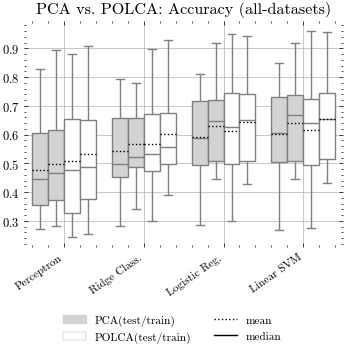

In [13]:
classifier_means = df_class_long.groupby("Classifier")["Value"].mean().sort_values(ascending=True)
classifier_ranks = {classifier: rank for rank, classifier in enumerate(classifier_means.index)}
df_sorted = df_class_long.sort_values(
    by=["Classifier", "Method"], key=lambda x: x.map(classifier_ranks) if x.name == "Classifier" else x
)
df = df_sorted.reset_index(drop=True).copy()

df["Method"] = df["Method"] + "-" + df["Split"]
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.boxplot(
    data=df,
    x="Classifier",
    y="Value",
    hue="Method",
    fill=True,
    palette=["lightgray", "lightgray", "white", "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
)
plt.xlabel("")
# ax.set_ylabel("Accuary across all datasets", fontsize="small")
ax.set_ylabel(None)
ax.set_xticks(range(len(df.Classifier.unique())))
ax.legend([])
tlabels = [t.get_text() for t in ax.get_xticklabels()]
# tlabels[tlabels.index("Gaussian Naive Bayes")] = "Gauss. NB"
tlabels[tlabels.index("Logistic Regression")] = "Logistic Reg."
tlabels[tlabels.index("Ridge Classifier")] = "Ridge Class."
ax.set_xticklabels(tlabels, rotation=35, ha="right", fontsize="xx-small")
ax.set_title("PCA vs. POLCA: Accuracy (all-datasets)", fontsize="small")
ax.grid()

PCA_patch = mpatches.Patch(color="lightgray", label="PCA(test/train)")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA(test/train)", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median")

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)

sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/classifier_metric_comparison_boxplot_methods.pdf", dpi=300, bbox_inches="tight")

In [14]:
# Reshape the DataFrame
df_metrics_long = (
    df_metrics.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_3": "Metric", "level_4": "Method", 0: "Value"})
)
df_metrics_long

,Dataset,N,Split,Metric,Method,Value
0,sinusoidal,8,test,NRMSE,PCA,0.1888
1,sinusoidal,8,test,NRMSE,POLCA,0.0157
2,sinusoidal,8,test,PSNR,PCA,20.4992
3,sinusoidal,8,test,PSNR,POLCA,42.7879
4,sinusoidal,8,test,SSIM,PCA,0.8351
...,...,...,...,...,...,...
187,tissue,8,train,NRMSE,POLCA,0.3747
188,tissue,8,train,PSNR,PCA,26.9254
189,tissue,8,train,PSNR,POLCA,27.3031
190,tissue,8,train,SSIM,PCA,0.6539


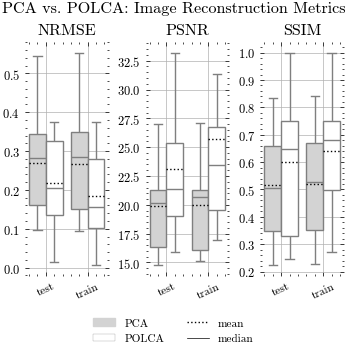

In [15]:
df = df_metrics_long
fig, axs = plt.subplots(1, 3, figsize=(3.5, 3.5))

for ax, metric, title in zip(axs, ["NRMSE", "PSNR", "SSIM"], ["NRMSE", "PSNR", "SSIM"]):
    ax = sns.boxplot(
        data=df[df["Metric"] == metric],
        x="Split",
        y="Value",
        hue="Method",
        fill=True,
        palette={"PCA": "lightgray", "POLCA": "white"},
        gap=0.0,
        showmeans=True,
        meanprops={"ls": ":", "c": "k"},
        meanline=True,
        showfliers=False,
        fliersize=0.5,
        ax=ax,
        legend=False,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontsize="small")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["test", "train"], rotation=25, ha="center", fontsize="xx-small")
    ax.grid()


plt.suptitle("PCA vs. POLCA: Image Reconstruction Metrics", fontsize="small")

PCA_patch = mpatches.Patch(color="lightgray", label="PCA")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median", lw=0.5)

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)
# Tweak the visual presentation
sns.despine(trim=True, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/image_metrics_comparison_boxplot.pdf", dpi=300, bbox_inches="tight")

In [16]:
df_class_labels = read_class_csv_files(f"experiments_64x64_6_labels/*/classification_metrics_*.csv")
df_class_labels = df_class_labels.xs("POLCA", axis=1, level=1)
df_class_labels.head(20)

ACC        F1
Dataset N  Classifier          Split                    
mnist   11 Linear SVM          test   0.991800  0.991799
                               train  0.999950  0.999950
           Logistic Regression test   0.991800  0.991798
                               train  0.999950  0.999950
           Perceptron          test   0.991700  0.991699
                               train  0.999833  0.999833
           Ridge Classifier    test   0.987700  0.987699
                               train  0.996617  0.996616
fmnist  8  Linear SVM          test   0.913100  0.913336
                               train  0.998950  0.998950
           Logistic Regression test   0.913000  0.913253
                               train  0.998850  0.998850
           Perceptron          test   0.911500  0.911340
                               train  0.998167  0.998167
           Ridge Classifier    test   0.908400  0.906793
                               train  0.987383  0.987206
breast  8  Linear SVM          test   0.814103  0.794083
                               train  1.000000  1.000000
           Logistic Regression test   0.826923  0.808284
                               train  1.000000  1.000000

In [17]:
df_class_labels_aggregated = df_class_labels.groupby(level=["Dataset", "Split"]).mean().round(2)
df_class_labels_aggregated

ACC    F1
Dataset   Split            
blood     test   0.95  0.95
          train  1.00  1.00
breast    test   0.83  0.81
          train  1.00  1.00
chest     test   0.45  0.03
          train  0.45  0.03
derma     test   0.74  0.72
          train  0.99  0.99
fmnist    test   0.91  0.91
          train  1.00  1.00
mnist     test   0.99  0.99
          train  1.00  1.00
oct       test   0.74  0.71
          train  1.00  1.00
organa    test   0.87  0.87
          train  0.99  0.99
organc    test   0.87  0.87
          train  0.99  0.99
organs    test   0.73  0.72
          train  0.99  0.99
path      test   0.85  0.84
          train  1.00  1.00
pneumonia test   0.85  0.84
          train  1.00  1.00
retina    test   0.49  0.47
          train  1.00  1.00
tissue    test   0.55  0.54
          train  0.88  0.86

In [18]:
latex_table = df_class_labels_aggregated.to_latex(
    multicolumn_format="c",
    # multirow_align="c",
    # hrules = True,
    caption="""Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSRN), Structural Similarity Index Metric,
    Accuracy (ACC) and F1-Score (F1).
    """,
    label="tab:joit_classifier_metrics_comparison",
    position="htbp",
    float_format="%.2f",
)
latex_table = latex_table.replace(
    "\\label{tab:joit_classifier_metrics_comparison}",
    "\\label{tab:joit_classifier_metrics_comparison}\n \\centering \n \\small\n",
)
latex_table = re.sub("multirow.t.", "multirow[c]", latex_table)
latex_table = re.sub(r"\\cline..-...", "", latex_table)
latex_table = re.sub(r"NaN", "", latex_table)

print(latex_table)

\begin{table}[htbp]
\caption{Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSRN), Structural Similarity Index Metric,
    Accuracy (ACC) and F1-Score (F1).
    }
\label{tab:joit_classifier_metrics_comparison}
 \centering 
 \small

\begin{tabular}{llrr}
\toprule
 &  & ACC & F1 \\
Dataset & Split &  &  \\
\midrule
\multirow[c]{2}{*}{blood} & test & 0.95 & 0.95 \\
 & train & 1.00 & 1.00 \\
\cline{1-4}
\multirow[c]{2}{*}{breast} & test & 0.83 & 0.81 \\
 & train & 1.00 & 1.00 \\
\cline{1-4}
\multirow[c]{2}{*}{chest} & test & 0.45 & 0.03 \\
 & train & 0.45 & 0.03 \\
\cline{1-4}
\multirow[c]{2}{*}{derma} & test & 0.74 & 0.72 \\
 & train & 0.99 & 0.99 \\
\cline{1-4}
\multirow[c]{2}{*}{fmnist} & test & 0.91 & 0.91 \\
 & train & 1.00 & 1.00 \\
\cline{1-4}
\multirow[c]{2}{*}{mnist} & test & 0.99 & 0.99 \\
 & train & 1.00 & 1.00 \\
\cline{1-4}
\multirow[c]{2}{*}{oct} & test & 0.74 & 0.71 \\


In [19]:
# Reshape the DataFrame to long format
df_class_labels_long = df_class_labels.reset_index()
df_class_labels_long.head(30)

,Dataset,N,Classifier,Split,ACC,F1
0,mnist,11,Linear SVM,test,0.991800,0.991799
1,mnist,11,Linear SVM,train,0.999950,0.999950
2,mnist,11,Logistic Regression,test,0.991800,0.991798
3,mnist,11,Logistic Regression,train,0.999950,0.999950
4,mnist,11,Perceptron,test,0.991700,0.991699
5,mnist,11,Perceptron,train,0.999833,0.999833
6,mnist,11,Ridge Classifier,test,0.987700,0.987699
7,mnist,11,Ridge Classifier,train,0.996617,0.996616
8,fmnist,8,Linear SVM,test,0.913100,0.913336
9,fmnist,8,Linear SVM,train,0.998950,0.998950


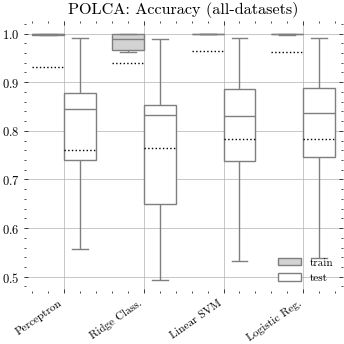

In [20]:
classifier_means = df_class_labels_long.groupby("Classifier")["ACC"].mean().sort_values(ascending=True)
classifier_ranks = {classifier: rank for rank, classifier in enumerate(classifier_means.index)}
df_sorted = df_class_labels_long.sort_values(
    by=["Classifier"], key=lambda x: x.map(classifier_ranks) if x.name == "Classifier" else x
)
df = df_sorted.reset_index(drop=True).copy()

# df["Method"] = df["Method"] + "-" + df["Split"]
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.boxplot(
    data=df,
    x="Classifier",
    y="ACC",
    hue="Split",
    fill=True,
    palette=["lightgray", "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
)
plt.xlabel("")
# ax.set_ylabel("Accuary across all datasets", fontsize="small")
ax.set_ylabel(None)
ax.set_xticks(range(len(df.Classifier.unique())))
ax.legend(loc="lower right")
tlabels = [t.get_text() for t in ax.get_xticklabels()]
# tlabels[tlabels.index("Gaussian Naive Bayes")] = "Gauss. NB"
tlabels[tlabels.index("Logistic Regression")] = "Logistic Reg."
tlabels[tlabels.index("Ridge Classifier")] = "Ridge Class."
ax.set_xticklabels(tlabels, rotation=35, ha="right", fontsize="xx-small")
ax.set_title("POLCA: Accuracy (all-datasets)", fontsize="small")
ax.grid()

# PCA_patch = mpatches.Patch(color="lightgray", label="PCA(test/train)")
# POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA(test/train)", edgecolor="k", lw=0.1)
# means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
# median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median")

# fig.legend(
#     handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
#     loc="outside lower center",
#     fontsize="xx-small",
#     ncols=2,
#     borderaxespad=0.0,
# )

sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/classifier_metric_comparison_boxplot_methods.pdf", dpi=300, bbox_inches="tight")

In [21]:
(64 * 64) ** (1 / 4)

8.0

In [22]:
df_loss = read_loss_interaction_csv_files(f"{experiment}/*/loss_interaction_report.csv")

# Step 1: Find the most common relationship for each unique losses value
most_common_relationship = (
    df_loss.groupby("losses")["relationship"].agg(lambda x: x.value_counts().index[0]).reset_index()
)

# Step 2: Create a dictionary for mapping
relationship_mapping = most_common_relationship.set_index("losses")["relationship"].to_dict()

# Step 3: Replace the values in the 'relationship' column
df_loss["common_relationship"] = df_loss["losses"].map(relationship_mapping)

# Step 4: Define the order of relationships from worst to best
relationship_order = [
    "Strongly Conflicting",
    "Conflicting",
    "Weakly Conflicting",
    "Weakly Cooperative",
    "Cooperative",
    "Strongly Cooperative",
]

# Step 5: Create a categorical column with the defined order
df_loss["relationship_category"] = pd.Categorical(
    df_loss["common_relationship"], categories=relationship_order, ordered=True
)

# Step 6: Sort the DataFrame based on the categorical column
df_loss = df_loss.sort_values("relationship_category")

# Step 7: Drop the helper column used for sorting
df_loss = df_loss.drop(columns=["relationship_category"])

# df_loss["losses"]  = "$" + df_loss["losses"] + "$"

df_loss

,Unnamed: 0,interactions,conflicts,conflict_rate,avg_similarity,relationship,Dataset,losses,common_relationship
0,0,6124,5720,0.934030,-0.537107,Strongly Conflicting,tissue,$\frac{com}{var}$,Strongly Conflicting
0,0,5918,4020,0.679284,-0.107175,Strongly Conflicting,derma,$\frac{com}{var}$,Strongly Conflicting
5,5,5277,510,0.096646,0.139164,Strongly Cooperative,retina,$\frac{com}{var}$,Strongly Conflicting
0,0,5770,5577,0.966551,-0.229768,Strongly Conflicting,pneumonia,$\frac{com}{var}$,Strongly Conflicting
0,0,5940,2710,0.456229,-0.098925,Weakly Conflicting,blood,$\frac{com}{var}$,Strongly Conflicting
...,...,...,...,...,...,...,...,...,...
5,5,6149,1467,0.238575,0.070269,Weakly Cooperative,path,$\frac{ort}{com}$,Strongly Cooperative
4,4,5770,541,0.093761,0.094994,Weakly Cooperative,pneumonia,$\frac{ort}{com}$,Strongly Cooperative
2,2,1463,79,0.053999,0.128728,Strongly Cooperative,SYNTH,$\frac{ort}{com}$,Strongly Cooperative
2,2,4831,836,0.173049,0.085718,Weakly Cooperative,breast,$\frac{ort}{com}$,Strongly Cooperative


In [23]:
df_loss["losses"].unique()

array(['$\\frac{com}{var}$', '$\\frac{rec}{com}$', '$\\frac{ort}{var}$',
       '$\\frac{rec}{var}$', '$\\frac{rec}{ort}$', '$\\frac{ort}{com}$'],
      dtype=object)

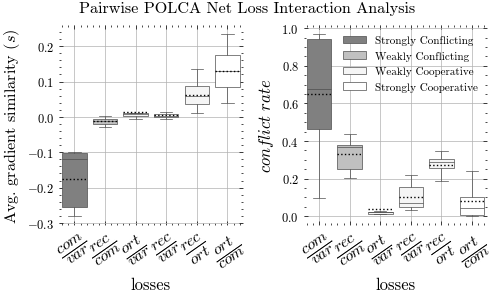

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))
palette = {
    "Strongly Conflicting": "gray",
    "Weakly Conflicting": "silver",
    "Weakly Cooperative": "whitesmoke",
    "Strongly Cooperative": "white",
}

ax1 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="avg_similarity",
    hue="common_relationship",
    fill=True,
    palette=palette,
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",
    linewidth=0.5,
    ax=ax1,
    saturation=0.6,
)
ax1.grid()
ax1.set_ylabel("Avg. gradient similarity ($s$)", fontsize="small")
similarity_form = r"$s=\frac{\nabla L_i \cdot \nabla L_j}{|\nabla L_i| |\nabla L_j|}$"
similarity_form += r", $s<1\mathrm{e}{-1}~(\text{conflict})$"
# ax1.set_title(similarity_form,fontsize="medium")
ax1.set_xticks(range(len(df_loss["losses"].unique())))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=35, ha="center", fontsize="large")
ax1.legend([])

ax2 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="conflict_rate",
    hue="common_relationship",
    fill=True,
    palette=palette,
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",
    linewidth=0.5,
    ax=ax2,
    saturation=0.6,
)
ax2.grid()
ax2.set_ylabel("$conflict$ $rate$")
# ax2.set_title("$rate = conflicts / interactions$",fontsize="medium")
ax2.set_xticks(range(len(df_loss["losses"].unique())))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=35, ha="center", fontsize="large")
ax2.legend()
plt.suptitle("Pairwise POLCA Net Loss Interaction Analysis", fontsize="small")
sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/pairwise_loss_conflicts_boxplot.pdf", dpi=300, bbox_inches="tight")